## Example with CNN-LSTM on live BTC close price using the full data

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.7 MB/s 
     |████████████████████████████████| 70 kB 7.4 MB/s 
     |████████████████████████████████| 1.1 MB 66.9 MB/s 
     |████████████████████████████████| 112 kB 80.3 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
     |████████████████████████████████| 288 kB 73.9 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 271 kB 95.9 MB/s 
     |████████████████████████████████| 144 kB 103.5 MB/s 
     |████████████████████████████████| 749 kB 82.9 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [4]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.sats2backtest as s2b
import src.timeutils as tu

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [5]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (171015, 8)


### Generate Candles and build features from technical analysis

In [6]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()

# Generate normalized timeseries

In [7]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

ts_btc.x_candles
ts_btc.x_time
ts_btc.y[-10:]

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


[0.37053604840141496,
 0.3706259133308751,
 0.3714532716024092,
 0.37156143729258007,
 0.3711712942097668,
 0.37148741481269043,
 0.3715760961108608,
 0.37166477740903114,
 0.3717306965670141,
 0.3720383496537879]

## Train CNN-LSTM model using full or part of data set

In [8]:
btc_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.95)
btc_model.sats2model()

In [9]:
datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')

'220709_08_45'

In [10]:
MODELDATE_TO_SAVE = datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')
PRESAVED_MODELDATE = "220708_18_30"

if PRESAVED_MODELDATE == MODELDATE_TO_SAVE :
  model_name = f"model/LSTM_CNN_pretrained_{MODELDATE_TO_SAVE}"
else:
  model_name = "model/LSTM_CNN_model"

btc_model.sats2train(model_name, save_model = True, epochs=20)

Epoch 1/20
12/12 [==============================] - 29s 495ms/step - loss: 0.1966 - val_loss: 0.1876
Epoch 2/20
12/12 [==============================] - 1s 99ms/step - loss: 0.0546 - val_loss: 0.0736
Epoch 3/20
12/12 [==============================] - 1s 98ms/step - loss: 0.0352 - val_loss: 0.0302
Epoch 4/20
12/12 [==============================] - 1s 101ms/step - loss: 0.0190 - val_loss: 0.0077
Epoch 5/20
12/12 [==============================] - 1s 91ms/step - loss: 0.0269 - val_loss: 0.0286
Epoch 6/20
12/12 [==============================] - 1s 91ms/step - loss: 0.0360 - val_loss: 0.0545
Epoch 7/20
12/12 [==============================] - 1s 90ms/step - loss: 0.0248 - val_loss: 0.0373
Epoch 8/20
12/12 [==============================] - 1s 99ms/step - loss: 0.0121 - val_loss: 0.0070
Epoch 9/20
12/12 [==============================] - 1s 100ms/step - loss: 0.0099 - val_loss: 0.0101
Epoch 10/20
12/12 [==============================] - 1s 101ms/step - loss: 0.0088 - val_loss: 0.0047
Epoc

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


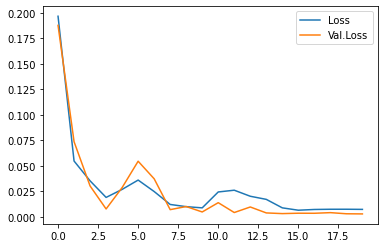

In [11]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

### Retrain for longer

In [33]:
btc_model.sats2train(model_name, save_model = True, epochs=2000)

Epoch 1/2000
12/12 [==============================] - 1s 110ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 2/2000
12/12 [==============================] - 1s 93ms/step - loss: 0.0026 - val_loss: 0.0073
Epoch 3/2000
12/12 [==============================] - 1s 93ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 4/2000
12/12 [==============================] - 1s 93ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 5/2000
12/12 [==============================] - 1s 93ms/step - loss: 0.0091 - val_loss: 0.0145
Epoch 6/2000
12/12 [==============================] - 1s 93ms/step - loss: 0.0105 - val_loss: 0.0110
Epoch 7/2000
12/12 [==============================] - 1s 93ms/step - loss: 0.0057 - val_loss: 0.0086
Epoch 8/2000
12/12 [==============================] - 1s 93ms/step - loss: 0.0048 - val_loss: 0.0077
Epoch 9/2000
12/12 [==============================] - 1s 94ms/step - loss: 0.0045 - val_loss: 0.0063
Epoch 10/2000
12/12 [==============================] - 1s 94ms/step - loss: 0.0045 - val_l

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


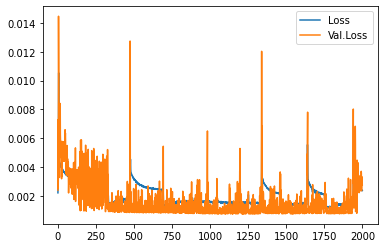

In [34]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [35]:
btc_model.sats2pred()

In [36]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(btc_model.scaler, ts_btc.candles, btc_model.preds)

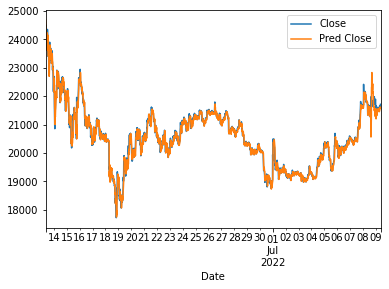

In [37]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = 1)
df_preds_true.dropna().plot()

## Test on pretrained model

In [38]:
USE_PRETRAINED = False

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.95)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = True)
loaded_model.preds

array([[0.39906588],
       [0.39819536],
       [0.39491045],
       ...,
       [0.37115443],
       [0.37087792],
       [0.37096652]], dtype=float32)

In [39]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(loaded_model.scaler, ts_btc.candles, loaded_model.preds)

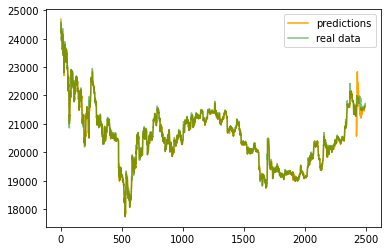

In [40]:
plt.plot(preds, color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point+ts_btc.step_back:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

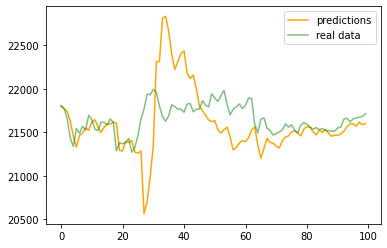

In [41]:
plt.plot(preds[-100:], color='orange', label='predictions')
plt.plot(true_vals[-100:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

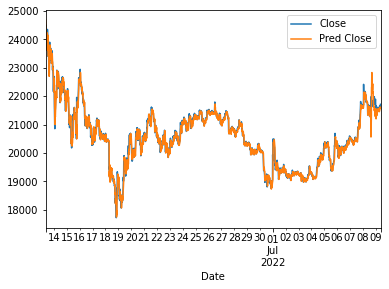

In [42]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = 1)
df_preds_true.dropna().plot()

In [43]:
df_preds_true.dropna()

,Close,Pred Close
Date,,
2022-06-13 08:45:00,24182.60,24683.704415
2022-06-13 09:00:00,24512.99,24588.093257
2022-06-13 09:15:00,24301.38,24227.307611
2022-06-13 09:30:00,23925.86,24311.783228
2022-06-13 09:45:00,24052.83,24283.842905
...,...,...
2022-07-09 07:45:00,21654.72,21596.544164
2022-07-09 08:00:00,21664.46,21596.681640
2022-07-09 08:15:00,21674.20,21571.120957


In [44]:
np.array(true_vals[btc_model.split_point+ts_btc.step_back+1:])

array([24182.6 , 24512.99, 24301.38, ..., 21674.2 , 21681.44, 21715.23])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
/content/drive/MyDrive/Colab Notebooks/sats4u/src/sats2backtest.py:216: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes[1].stem(wallet_hist_df.index, wallet_hist_df.iloc[:, 1])


Initial time 2022-06-13 08:45:00
Final time 2022-07-09 08:45:00
Fee: 0.025
----------------------
Buy      665 ( 629 ok 36 ko )
Avg PCT gain: 1.0054716019003314
Avg PCT loss: 0.9978557315587904
Wins  PCT   0.9458646616541353
Avg PCT Gain.    1.0054716019003314
No-op    0
Wallet   67405.01000000011
Drawback -375.73425000000344
Kelly Fraction    0.8921393674278244
Total earned 67405.01000000011


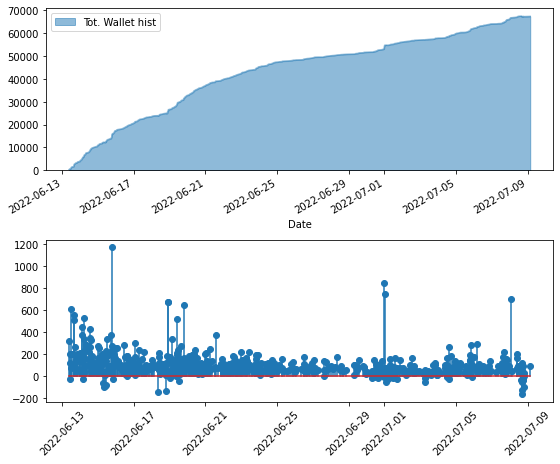

In [55]:
wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna(), step_back=+ 2,
                                                    long_short = "long", fee=0.025, cutoff_long = 20. ,cutoff_short = 20.0)
s2b.show_backtest_results(wallet,wallet_hist_df)